# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 49.1 MB/s eta 0:00:00


In [2]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [3]:
cursor = con.cursor()

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [4]:
cursor.execute("SELECT hire_date FROM employees WHERE hire_date = (SELECT max(hire_date) FROM employees) OR hire_date = (SELECT min(hire_date) FROM employees) GROUP BY hire_date")
myresult = cursor.fetchall()
print (myresult)

[(datetime.date(1985, 1, 1),), (datetime.date(2000, 1, 28),)]


Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [5]:
import pandas as pd

In [6]:
query = """
SELECT s.emp_no, s.salary, s.from_date, s.to_date
FROM salaries AS s
JOIN (
    SELECT emp_no, MAX(to_date) AS max_to_date
    FROM salaries
    GROUP BY emp_no
) AS last_salaries
ON s.emp_no = last_salaries.emp_no AND s.to_date = last_salaries.max_to_date
"""

with con.cursor() as cur:
    cur.execute(query)
    rows = cur.fetchall()
    field_names = [i[0] for i in cur.description]
    res = pd.DataFrame(rows, columns=field_names)

    print(res.columns.tolist())
    print(res.shape)
    print(res.head(3))

['emp_no', 'salary', 'from_date', 'to_date']
(300180, 4)
   emp_no  salary   from_date     to_date
0   10001   88958  2002-06-22  9999-01-01
1   10002   72527  2001-08-02  9999-01-01
2   10003   43311  2001-12-01  9999-01-01


Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [7]:
from datetime import date

In [8]:
count_not_9999 = res.loc[res['to_date'] != date(9999, 1, 1)]
count_not_9999

,emp_no,salary,from_date,to_date
7,10008,52668,2000-03-10,2000-07-31
10,10011,56753,1996-01-21,1996-11-09
14,10015,40000,1992-09-19,1993-08-22
20,10021,84169,2002-02-06,2002-07-15
24,10025,57157,1997-08-14,1997-10-15
...,...,...,...,...
300158,499978,41746,1997-07-09,1997-12-14
300162,499982,39659,2000-04-07,2000-05-16
300168,499988,102085,2001-07-22,2001-10-09
300169,499989,70425,2000-10-28,2001-03-07


In [9]:
count_9999 = res.loc[res['to_date'] == date(9999, 1, 1)]
print(f"Кількість значень, рівних 9999-01-01: {count_9999}")

Кількість значень, рівних 9999-01-01:         emp_no  salary   from_date     to_date
0        10001   88958  2002-06-22  9999-01-01
1        10002   72527  2001-08-02  9999-01-01
2        10003   43311  2001-12-01  9999-01-01
3        10004   74057  2001-11-27  9999-01-01
4        10005   94692  2001-09-09  9999-01-01
...        ...     ...         ...         ...
300175  499995   52868  2002-06-01  9999-01-01
300176  499996   69501  2002-05-12  9999-01-01
300177  499997   83441  2001-08-26  9999-01-01
300178  499998   55003  2001-12-25  9999-01-01
300179  499999   77303  2001-11-29  9999-01-01

[240124 rows x 4 columns]


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

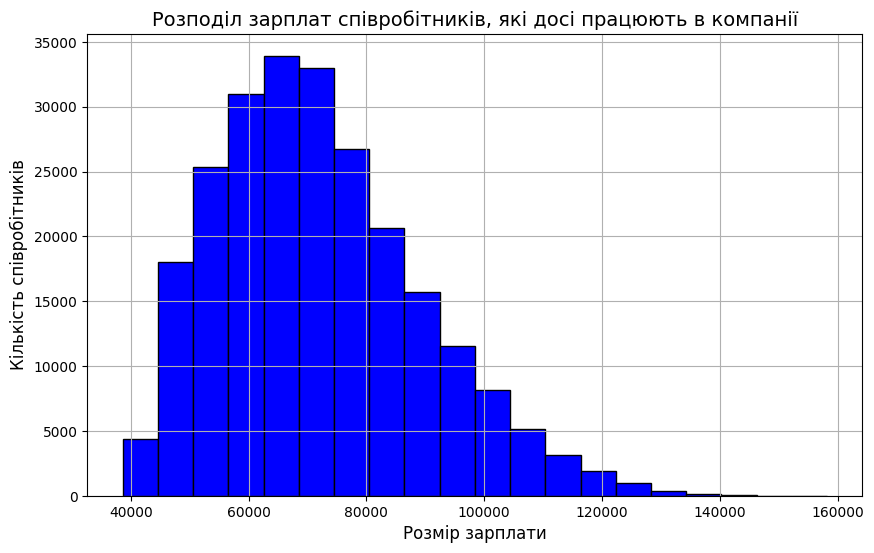

In [10]:
import matplotlib.pyplot as plt
working_employees = count_9999
plt.figure(figsize=(10, 6))
plt.hist(working_employees['salary'], bins=20, color='blue', edgecolor='black')
plt.title('Розподіл зарплат співробітників, які досі працюють в компанії', fontsize=14)
plt.xlabel('Розмір зарплати', fontsize=12)
plt.ylabel('Кількість співробітників', fontsize=12)
plt.grid(True)
plt.show()

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [11]:
con.close()